# Finetuning ResNet50 and Clustering Based on CombinedFeatures using Different Data Subsets

**This notebook runs on Kaggle**

Fine-tuning ResNet50 models using different data subsets and evaluation of k-means clustering based on respective image and text (Sentence Transformer) features.

* Data subsets: 10, 20, 30, ..., 70 unique labels with the highest number of parts.
* A model is fine-tuned with each data subset (10, 20, ..., 70 classes) and features are extracted for respective image subset.
* Text features are extracted from English item names using Sentence Transformer.
* Image and text features are stacked and clustered using k-means.

In [1]:
!pip install sentence_transformers

In [2]:
# models
import tensorflow as tf
print('TF Version:', tf.__version__)
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# clustering
from sklearn.cluster import KMeans

# For embedding text
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize

# for everything else
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for helper modules
import sys
sys.path.append('/kaggle/input/helper-cnn') # uncomment on local system
import helper_cnn as hp
sys.path.append('/kaggle/input/image_feature_extraction') # change to '../../src/' if run locally
from image_feature_extraction import dump_to_pickle_file, load_from_pickle_file, map_parts_to_features
sys.path.append('/kaggle/input/evaluation') # change to '../../src/' if run locally
import evaluation as ev
sys.path.append('/kaggle/input/create_bow') # change to '../../src/' if run locally
from create_bow import pre_process_corpus

2024-02-19 18:21:28.927711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 18:21:28.927760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 18:21:28.929373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF Version: 2.15.0


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 19 18:21:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Paths and filenames - change depending on your setup & preferences

In [1]:
input_directory = '../input/syrus-image-segmented'
processed_data_csv_file = 'SyrusMasterDataAnonymisedProc.csv'
output_directory = '../working/'
input_images_directory = f'{input_directory}/SyrusImageSegmented/SyrusImageSegmented'
models_path = "/kaggle/input/finetuned-resnet50-different-classes"

### Constants

In [5]:
IMG_DIMS = (353, 500) # mode image dimensions
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)

### Data loading and preparation

In [8]:
df= pd.read_csv(os.path.join(input_directory, processed_data_csv_file), index_col=0)
df = df[df['hasImage']==1]
df['FileName'] = df['ItemNumber'].apply(lambda x: x+".jpeg")
df.head()

,ItemNumber,EnglishItemName,GermanItemName,EnglishItemNameClean,GermanItemNameClean,Weight_kg,Entity,CurrentFamily,CurrentSyntegonSubFamily,PVFamily,PVSubFamily,target,hasImage,FileName
0,A3,BAR GRIP,BAR GRIP,Bar grip,Bar grip,NaN,104.0,BAR PARTS,BAR,AXLE & SHAFT PARTS,AXLE,AXLE & SHAFT PARTS_AXLE,1,A3.jpeg
9,A12,BAR SPACING,ABSTANDSTRANGE,Bar spacing,Abstandstrange,NaN,101.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS,1,A12.jpeg
10,A13,BAR,Leiste,Bar,Leiste,NaN,110.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS,1,A13.jpeg
21,A24,BAR-FEEDER DECK MTG,BAR-FEEDER DECK MTG,Bar feeder deck mtg,Bar feeder deck mtg,NaN,104.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS,1,A24.jpeg
22,A25,BAR,Leiste,Bar,Leiste,NaN,110.0,BAR PARTS,BAR,BAR PARTS,BARS,BAR PARTS_BARS,1,A25.jpeg


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7578 entries, 0 to 13449
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ItemNumber                7578 non-null   object 
 1   EnglishItemName           7509 non-null   object 
 2   GermanItemName            7509 non-null   object 
 3   EnglishItemNameClean      7509 non-null   object 
 4   GermanItemNameClean       7509 non-null   object 
 5   Weight_kg                 6446 non-null   float64
 6   Entity                    7509 non-null   float64
 7   CurrentFamily             7578 non-null   object 
 8   CurrentSyntegonSubFamily  7578 non-null   object 
 9   PVFamily                  7578 non-null   object 
 10  PVSubFamily               7578 non-null   object 
 11  target                    7578 non-null   object 
 12  hasImage                  7578 non-null   int64  
 13  FileName                  7578 non-null   object 
dtypes: float64(2

In [10]:
# Check the number of unique classes for the image dataset
df.target.nunique()

95

In [11]:
# Remove classes that have less than 10 images
target_counts = df.target.value_counts()
selected_targets = target_counts[target_counts >= 10].index.to_list()
num_classes = len(selected_targets)
print("The number of classes that have more than 10 images:",num_classes)

The number of classes that have more than 10 images: 73


In [12]:
# Remove the rows in dataframe which do not belong to the selected targets
df_selected = df[df['target'].isin(selected_targets)]
new_order = ['ItemNumber',  'FileName', 'hasImage', 'EnglishItemName', 'GermanItemName', 'EnglishItemNameClean', 'GermanItemNameClean', 'Weight_kg', 'Entity', 'CurrentFamily', 'CurrentSyntegonSubFamily', 'PVFamily', 'PVSubFamily', 'target']
df_selected = df_selected[new_order]
sorted_classes = df_selected.groupby('target').agg(count=('FileName', 'count')).sort_values(by='count', ascending=False).index.tolist()
print(sorted_classes)

['BAR PARTS_BARS', 'KNIFE PARTS_VERTICAL KNIFE', 'ROLLER PARTS_SIMPLE ROLLER', 'KNIFE PARTS_STRAIGHT KNIFE', 'KNIFE PARTS_OTHER', 'PUSHER PARTS_OTHER', 'ROLLER PARTS_SIMPLE DIVERSION & DEFLECTION ROLLER', 'BAR PARTS_LONG BARS', 'KNIFE PARTS_KNIFE BLADE', 'KNIFE PARTS_KNIFE HOLDER', 'PUSHER PARTS_PUSHER BLOCK', 'PUSHER PARTS_PUSHER PLATE', 'KNIFE PARTS_COUNTER HOLDER KNIFE', 'ROLLER PARTS_COMPLEX DIVERSION & DEFLECTION ROLLER', 'SLIDE PARTS_SLIDING BLOCK', 'ROLLER PARTS_COMPLEX DRIVE ROLLER', 'PUSHER PARTS_PUSHER PADDLE', 'PUSHER PARTS_SLIDE PUSHER', 'BAR PARTS_OTHER', 'BAR PARTS_RIDER BAR', 'PUSHER PARTS_PUSHER LUG IN U', 'BELOW PARTS_BELLOW', 'ROLLER PARTS_COMPLEX ROLLER', 'KNIFE PARTS_COUNTER HOLDER BLOCK', 'KNIFE PARTS_KNIFE SHIM', 'PUSHER PARTS_PUSHER AXLE', 'PUSHER PARTS_LOCKING PUSHER', 'BEAM PARTS_BEAM', 'KNIFE PARTS_KNIFE OTHER', 'KNIFE PARTS_STRAIGHT CUTTING KNIFE', 'ROLLER PARTS_SIMPLE FLANGING ROLLER', 'ROLLER PARTS_OTHER', 'PUSHER PARTS_PUSHER LEVER', 'BAR PARTS_FLAT BAR', 

In [13]:
df_selected.shape

(7480, 14)

In [14]:
# Train - Validation - test split (80% - 10% - 10%)
df_train_all, df_val_test = train_test_split(df_selected, train_size=0.8, random_state=42, shuffle=True, stratify=df_selected["target"])
df_val_all, df_test_all = train_test_split(df_val_test, test_size=0.5, random_state=42, shuffle=True, stratify=df_val_test["target"])
print("Train set: ", round(len(df_train_all) / len(df_selected) * 100, 0), "%", df_train_all.shape)
print("Validation set: ", round(len(df_val_all) / len(df_selected) * 100, 0), "%", df_val_all.shape)
print("Test set: ", round(len(df_test_all) / len(df_selected) * 100, 0), "%", df_test_all.shape)

Train set:  80.0 % (5984, 14)
Validation set:  10.0 % (748, 14)
Test set:  10.0 % (748, 14)


In [15]:
# limiting the model to only train on and predict 'target' of parts

x_col = 'FileName' # column in the df with local paths to images
y_col = "target" # column in the df with the names of the classes

print("'{}' column contains {} unique classes".format(y_col, df_train_all[y_col].unique().shape[0]))

'target' column contains 73 unique classes


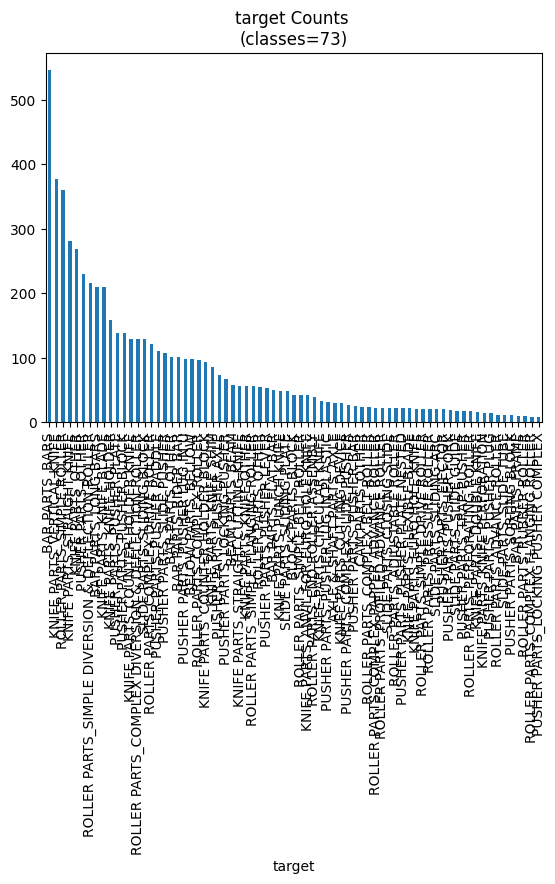

In [16]:
hp.plot_class_balances(df_train_all, y_col)

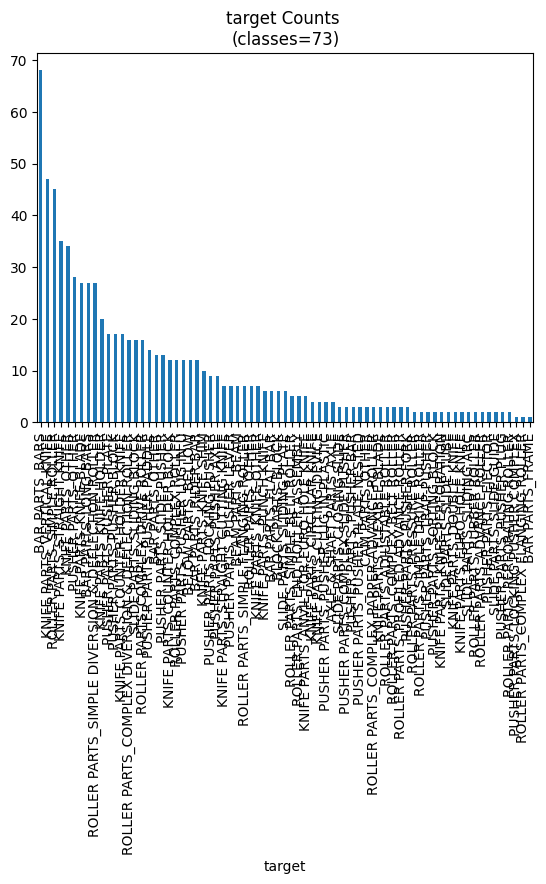

In [17]:
hp.plot_class_balances(df_val_all, y_col)

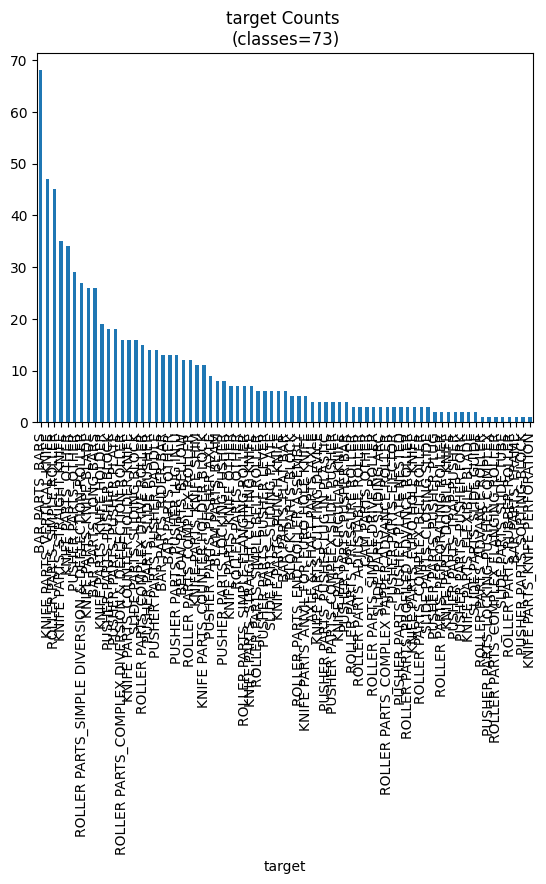

In [18]:
hp.plot_class_balances(df_test_all, y_col)

### Helper functions

In [21]:
# Function to create generator objects for train, valiadation and test sets
def get_generators(i):
    train_classes = sorted_classes[0:i]
    print(train_classes)
    
    df_train = df_train_all[df_train_all['target'].isin(train_classes)]
    df_val = df_val_all[df_val_all['target'].isin(train_classes)]
    df_test = df_test_all[df_test_all['target'].isin(train_classes)]
    
    datagen_train=tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    train_generator=datagen_train.flow_from_dataframe(
        dataframe=df_train,
        directory=input_images_directory,
        shuffle=True,
        x_col=x_col,
        y_col=y_col,
        classes=train_classes,
        class_mode='sparse',
        target_size=IMG_DIMS,
        batch_size=BATCH_SIZE
    )
    
    datagen_val=tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    val_generator=datagen_val.flow_from_dataframe(
        dataframe=df_val,
        directory=input_images_directory,
        x_col=x_col,
        y_col=y_col,
        class_mode='sparse',
        classes=train_classes,
        shuffle=False,
        target_size=IMG_DIMS,
        batch_size=BATCH_SIZE)

    test_generator = datagen_val.flow_from_dataframe(
        dataframe=df_test,
        directory=input_images_directory,
        x_col=x_col,
        y_col=y_col,
        class_mode='sparse',
        classes=train_classes,
        shuffle=False,
        target_size=IMG_DIMS,
        batch_size=BATCH_SIZE)
    
    def plot_images(augmented_images, rows=4, cols=4):
        fig, axs = plt.subplots(rows, cols, figsize=(4*rows, 4*cols))
        for i in range(0, rows):
            for j in range(0, cols):
                axs[i, j].imshow(augmented_images[(i+1)*(j+1)]/255)
                axs[i, j].axis('off')
        plt.tight_layout()
        plt.show()
        
    generated_images = [train_generator[i][0][10] for i in range(5)]
    plot_images(generated_images, 2, 2) # plots only 4 images
    
    # Verify the target label encoder with the actual label name
    generated_classes = [train_generator[i][1][10] for i in range(5)]
    print(generated_classes)
    print(train_classes[int(generated_classes[1])])
    
    # Get the class-numbers for all the images in the training- and test-sets
    cls_train = train_generator.classes
    cls_test = test_generator.classes
    print(f"number of elements in train_generator: {len(cls_train)}, test_generator: {len(cls_test)}")
    
    return(train_generator, val_generator, test_generator)

In [22]:
# Build the Model using ResNet50
def get_model():
    
    model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
#     model.summary()
    
    # points to last layer to ignore the top layer if the object instance include_top was set to True
    last_conv_layer = model.get_layer('conv5_block3_out')

    conv_model = Model(inputs=model.input,
                       outputs=last_conv_layer.output)

    # Start a new Keras Sequential model.
    new_model = Sequential()

    # Add the convolutional part of the model from above.
    new_model.add(conv_model)

    # The VGG model uses a global average pooling layer before the final dense layer
    # other models may just flatten the final convolutional layer or
    # use other pooling layers so make sure to check the original model architecture.
    new_model.add(tf.keras.layers.GlobalAveragePooling2D())

    # One could experiment with adding other layers like a dropout-layer which may prevent overfitting.
    new_model.add(tf.keras.layers.Dropout(0.2))

    # Add Dense Layer with ReLU Activation: Introduces non-linearity to the network, allowing it to learn complex patterns.
    # ReLU (Rectified Linear Unit) is preferred for its computational efficiency and effectiveness in training
    # deep neural networks by solving the vanishing gradient problem to some extent.
    new_model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

    new_model.add(tf.keras.layers.Dropout(0.2))

    # Add a final dense (aka. fully-connected) layer.
    # This is for combining features recognized in the image and calculating predictions
    # note that the number of nodes is the sameas the number of classes.
    new_model.add(tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))
    
    LEARNING_RATE = 1e-5
    optimizer = Adam(learning_rate=LEARNING_RATE)
    print(optimizer.lr.numpy())
    loss = 'sparse_categorical_crossentropy'
    lst_metrics = ['sparse_categorical_accuracy']
    new_model.compile(optimizer=optimizer, loss=loss, metrics=lst_metrics)

    # To fine tune the model, unfreeze the conv_model first:
    conv_model.trainable = True
    # and then freeze the layers you don't want to fine tune
    # Else it keeps running in inference mode, and won't fine tune
    # even if the layers are later set to trainable
    
    for layer in conv_model.layers:
      if (layer.name.split("_")[0] != 'conv5') | (layer.name.split("_")[-1] == 'bn'):
        layer.trainable = False
    
    return(new_model, lst_metrics)

In [24]:
df_selected = df_selected[df_selected['EnglishItemNameClean'].notna()]
EMBEDDER = SentenceTransformer('sentence-t5-large')

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [26]:
# Function extracting image features and performing clustering for the given number of classes
def perform_clustering(model, df, path_to_images, number_of_classes, dump_path):
    feature_extractor = keras.Model(inputs=model.inputs,outputs=model.layers[-5].output)
    image_features = map_parts_to_features(
        path_to_images, feature_extractor, dump_path, target_size=IMG_DIMS)
    image_feature_df = pd.DataFrame(list(image_features.items()), columns=['ItemNumber', 'ImageFeature'])
    # Strip ".jpeg"
    image_feature_df["ItemNumber"] = image_feature_df["ItemNumber"].apply(lambda x: x.strip('.jpeg'))
    df_merged = pd.merge(df, image_feature_df, on='ItemNumber', how='inner')
    classes = sorted_classes[0:number_of_classes]
    df_merged = df_merged[df_merged['target'].isin(classes)]
    df_merged.reset_index(inplace= True, drop = True)
    ImFeatureMatrix= np.vstack(df_merged['ImageFeature'])
    embeddings = EMBEDDER.encode(pre_process_corpus(df_merged['EnglishItemNameClean']))
    full_features_unnormalized = np.hstack((embeddings,ImFeatureMatrix))
    full_features = normalize(full_features_unnormalized, axis=0, norm='l1')
    true_k = 5 * number_of_classes
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=300, algorithm="elkan")
    print("Performing KMeans Clustering")
    labels = model.fit_predict(full_features)
    
    return df_merged.target, labels

### Running the finetuning, clustering and evaluation for different number of classes in a loop

In [29]:
labels_results = {} # class: (target_labels, predicted_labels)
evaluation_results = {} # class: (frequency_correct_clusters, frequency_clusters_above_threshold, frequency_main_target_per_cluster, ari)
for i in tqdm(range(10, 80, 10), desc="Running Classes"):
    print("Number of Classes:", i)
    model_pickle_file = os.path.join(models_path, f'resnet50_finetuned_segmented_classes{i}.pkl')
    feature_map_pickle_path = os.path.join(output_directory, f'features_resnet50_finetuned_segmented_classes{i}.pkl')
    if not os.path.exists(model_pickle_file):
        print("The Pickle File doesn't exists, Finetuning a new Model")
        train_generator, val_generator, test_generator = get_generators(i)

        # Defining steps size
        # Since the step_size can not be in decimal places, it has been rounded
        steps_train = round(train_generator.n / BATCH_SIZE)
        steps_val = round(val_generator.n / BATCH_SIZE)
        steps_test = round(test_generator.n / BATCH_SIZE)
        print(f'step size for training: {steps_train}, validation: {steps_val}, testing: {steps_test}')

        new_model, lst_metrics = get_model()

        # EarlyStopping callback
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)

        # Start finetuning
        total_epochs = 10
        history1 = new_model.fit(train_generator,
                                epochs=total_epochs,
                                steps_per_epoch=steps_train,
                                initial_epoch=0,
                                validation_data=val_generator,
                                callbacks = [early_stopping_cb]
                                )

        # Save the model
        model1_output_pickle_path = os.path.join(output_directory, f'resnet50_finetuned_segmented_classes{i}.pkl')
        dump_to_pickle_file(new_model, model1_output_pickle_path)
        
        hp.plot_training_history(history1, lst_metrics[0])
    
        # Show test accuracy
        result = new_model.evaluate(test_generator, steps=steps_test)
        print("Test-set classification accuracy: {0:.2%}".format(result[1]))
    else:
        print("Loading the Model from Pickle File")
        new_model = load_from_pickle_file(model_pickle_file)

    # Perform_clustering will extract features and perform clustering
    print("Performing Feature Extraction, Clustering and Evaluation")
    target_labels, predicted_labels = perform_clustering(new_model, df_selected, input_images_directory, i, feature_map_pickle_path)
    
    labels_results[i] = (target_labels, predicted_labels)
    
    # Evaluation
    frequency_correct_clusters, frequency_clusters_above_70, frequency_main_target_per_cluster, ari, _, _ = ev.evaluate_clustering_4_metrics(target_labels, predicted_labels)
    evaluation_results[i] = (frequency_correct_clusters, frequency_clusters_above_70, frequency_main_target_per_cluster, ari)
    print("Successfuly Clustered and Evaluated for Number of Classes:", i)

Running Classes:   0%|          | 0/7 [00:00<?, ?it/s]

Number of Classes: 10
Loading the Model from Pickle File
Performing Feature Extraction, Clustering and Evaluation


Extracting Features:   0%|          | 0/7578 [00:00<?, ?it/s]

Batches:   0%|          | 0/111 [00:00<?, ?it/s]

Performing KMeans Clustering


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Unique labels: 10
Percent of completely correct clusters: 24.28%
Percent of clusters with most frequent target frequency >= 70.0%: 94.0%
Percent of main target per cluster: 93.99%
ARI:  0.2977914610249213
Successfuly Clustered and Evaluated for Number of Classes: 10
Number of Classes: 20
Loading the Model from Pickle File
Performing Feature Extraction, Clustering and Evaluation


Extracting Features:   0%|          | 0/7578 [00:00<?, ?it/s]

Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Performing KMeans Clustering


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Unique labels: 20
Percent of completely correct clusters: 16.34%
Percent of clusters with most frequent target frequency >= 70.0%: 82.0%
Percent of main target per cluster: 86.12%
ARI:  0.2500437029979846
Successfuly Clustered and Evaluated for Number of Classes: 20
Number of Classes: 30
Loading the Model from Pickle File
Performing Feature Extraction, Clustering and Evaluation


Extracting Features:   0%|          | 0/7578 [00:00<?, ?it/s]

Batches:   0%|          | 0/189 [00:00<?, ?it/s]

Performing KMeans Clustering


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Unique labels: 30
Percent of completely correct clusters: 23.55%
Percent of clusters with most frequent target frequency >= 70.0%: 74.67%
Percent of main target per cluster: 83.44%
ARI:  0.21834916761329481
Successfuly Clustered and Evaluated for Number of Classes: 30
Number of Classes: 40
Loading the Model from Pickle File
Performing Feature Extraction, Clustering and Evaluation


Extracting Features:   0%|          | 0/7578 [00:00<?, ?it/s]

Batches:   0%|          | 0/207 [00:00<?, ?it/s]

Performing KMeans Clustering


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Unique labels: 40
Percent of completely correct clusters: 23.37%
Percent of clusters with most frequent target frequency >= 70.0%: 76.5%
Percent of main target per cluster: 78.76%
ARI:  0.19524456374167454
Successfuly Clustered and Evaluated for Number of Classes: 40
Number of Classes: 50
Loading the Model from Pickle File
Performing Feature Extraction, Clustering and Evaluation


Extracting Features:   0%|          | 0/7578 [00:00<?, ?it/s]

Batches:   0%|          | 0/218 [00:00<?, ?it/s]

Performing KMeans Clustering


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Unique labels: 50
Percent of completely correct clusters: 25.51%
Percent of clusters with most frequent target frequency >= 70.0%: 72.8%
Percent of main target per cluster: 78.71%
ARI:  0.16750086387433366
Successfuly Clustered and Evaluated for Number of Classes: 50
Number of Classes: 60
Loading the Model from Pickle File
Performing Feature Extraction, Clustering and Evaluation


Extracting Features:   0%|          | 0/7578 [00:00<?, ?it/s]

Batches:   0%|          | 0/226 [00:00<?, ?it/s]

Performing KMeans Clustering


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Unique labels: 60
Percent of completely correct clusters: 28.02%
Percent of clusters with most frequent target frequency >= 70.0%: 76.33%
Percent of main target per cluster: 76.83%
ARI:  0.14629949465556175
Successfuly Clustered and Evaluated for Number of Classes: 60
Number of Classes: 70
Loading the Model from Pickle File
Performing Feature Extraction, Clustering and Evaluation


Extracting Features:   0%|          | 0/7578 [00:00<?, ?it/s]

Batches:   0%|          | 0/231 [00:00<?, ?it/s]

Performing KMeans Clustering


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Unique labels: 70
Percent of completely correct clusters: 33.43%
Percent of clusters with most frequent target frequency >= 70.0%: 72.86%
Percent of main target per cluster: 77.81%
ARI:  0.14026827159423735
Successfuly Clustered and Evaluated for Number of Classes: 70
